In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
physical_devices = tf.config.list_physical_devices("GPU")
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass
from tensorflow import keras
from tensorflow.keras import layers
import io
import imageio
import time
from tools import get_image
from model import Fit

import glob
import pandas as pd

Matplotlib created a temporary config/cache directory at /localscratch-ssd/146738/matplotlib-9tm5zulp because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
lr_image_shape = [180, 320, 3]
image_shape = [720, 1280, 3]
window_size = 5
train_y_dir = "/home/niteya/work/ML/val/val_sharp/"
train_x_dir = "/home/niteya/work/ML/val/val_sharp_bicubic/"
results_path = '/home/niteya/work/ML/results/'
# checkpoint_dir = '/home/niteya/work/ML/model/training_checkpoints/'
# checkpoint_ext_all = ['ckpt-1907', 'ckpt_run_1-775', 'ckpt_run_2-2648']
checkpoint_dir = '/home/niteya/work/ML/model_1/training_checkpoints/'
checkpoint_ext_all = ['ckpt_run_2-942']

batch_div = 24
iterations = 100

In [22]:
dataset = tf.data.Dataset.from_generator(
    get_image,
    output_signature=(
        tf.TensorSpec(shape=(None, window_size, *lr_image_shape), dtype=tf.float32),
        tf.TensorSpec(shape=(None, *image_shape), dtype=tf.float32),
    ),
    args=(window_size, lr_image_shape, train_x_dir, train_y_dir, batch_div),
)
dataset = dataset.prefetch(tf.data.AUTOTUNE)
l = dataset.take(24)




 %%%%%% Loaded Checkpoint %%%%%% 




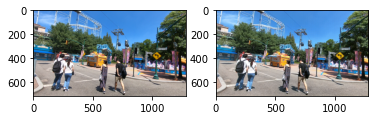

24.269083


In [23]:
for checkpoint_ext in checkpoint_ext_all:
    fit = Fit(lr_image_shape, image_shape, checkpoint_dir=checkpoint_dir, checkpoint_ext='ckpt',load_checkpoint=checkpoint_ext)
    results_psnr = []
    results_ssim = []
    j = 0
    for i in dataset:
        print(j, end="\r")
        out = fit.checkpoint.generator.predict(i[0], verbose=False)
        if j == 1:
            f, axarr = plt.subplots(1,2)
            axarr[0].imshow(i[1][0].numpy())
            axarr[1].imshow(out[0])
            plt.show()
        results_psnr.append(tf.image.psnr(out, i[1], max_val=1.0).numpy())
        results_ssim.append(tf.image.ssim(out, i[1], max_val=1.0).numpy())
        j += 1

    results_psnr = np.array(results_psnr).reshape(-1)
    results_ssim = np.array(results_ssim).reshape(-1)
    np.save(results_path + checkpoint_ext + '_pnsr', results_psnr)
    np.save(results_path + checkpoint_ext + '_ssim', results_ssim)
    print(results_psnr.mean())

In [27]:
data = {}
for pnsr in glob.glob("/home/niteya/work/ML/results/*pnsr.npy"):
    arr = np.load(pnsr)
    name = pnsr.split('/')[-1].rstrip('pnsr.npy')
    data[name] = [arr.mean()]
for ssim in glob.glob("/home/niteya/work/ML/results/*ssim.npy"):
    arr = np.load(ssim)
    name = ssim.split('/')[-1].rstrip('ssim.npy')
    data[name].append(arr.mean())

In [30]:
df = pd.DataFrame(data, index=['PNSR', 'SSIM'])
keys = list(data.keys())
df = df.rename(columns={keys[0]:'First Run', keys[1]:'Second Run',keys[3]:'Fixed Adam', keys[2]:'Sobol Loss'}).T

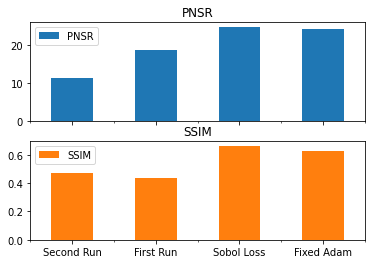

In [31]:
axes = df.plot.bar(rot=0, subplots=True)

In [ ]:
for checkpoint_ext in checkpoint_ext_all:
    hq = []
    lq = []
    ss = []
    fit = Fit(lr_image_shape, image_shape, checkpoint_dir=checkpoint_dir, checkpoint_ext='ckpt',load_checkpoint=checkpoint_ext)
    results_psnr = []
    results_ssim = []
    j = 0
    for i in l:
        print(j, end="\r")
        j += 1
        out = fit.checkpoint.generator.predict(i[0], verbose=False)
        hq.extend([*i[1].numpy()])
        lq.extend([*i[0][2].numpy()])
        ss.extend([*out])
#     hq = np.array(hq).reshape(-1, *image_shape)
#     out = np.array(out).reshape(-1, *image_shape)
#     lq = np.array(lq).reshape(-1, *lr_image_shape)
    imageio.mimsave(results_path + checkpoint_ext + '-hq.gif', hq, duration=1)
    imageio.mimsave(results_path + checkpoint_ext + '-lq.gif', lq, duration=1)
    imageio.mimsave(results_path + checkpoint_ext + '-ss.gif', ss, duration=1)

In [1]:
fit = Fit(lr_image_shape, image_shape, checkpoint_dir=checkpoint_dir, checkpoint_ext='ckpt',load_checkpoint=checkpoint_ext_all[2])
j = iter(dataset.take(1))

NameError: name 'Fit' is not defined

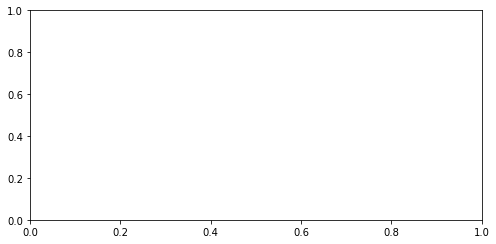

In [27]:
import time
from matplotlib.animation import FuncAnimation

plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

fig, ax = plt.subplots()

def gen():
    images = []
    for i in glob.glob('/home/niteya/work/ML/val/val_sharp/000/*.png'):
        images.append(i)
    sorted(images)
    while(True):
        for i in images:
            ax.imshow(imageio.imread(i))
            ax.set_axis_off() 

anim = FuncAnimation(fig, gen, frames=20, interval=50)
plt.show()